<a href="https://colab.research.google.com/github/ayotomiwaa/aml-numerai-2/blob/main/Numerai_Forward_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
# Install dependencies
!pip install -q numerapi pandas pyarrow matplotlib lightgbm scikit-learn cloudpickle lazypredict pandas-profiling

# Inline plots
%matplotlib inline

## 1. Dataset  

At a high level, the Numerai dataset is a tabular dataset that describes the stock market over time.

Each row represents a stock at a specific point in time, where `id` is the stock id and the `era` is the date. The `features` describe the attributes of the stock (eg. P/E ratio) known on the date and the `target` is a measure of 20-day returns.

The unique thing about Numerai's dataset is that it is `obfuscated`, which means that the underlying stock ids, feature names, and target definitions are anonymized. This makes it so that we can give this data out for free and so that it can be modeled without any financial domain knowledge (or bias!).

### Downloading the Dataset

In [13]:
# Initialize NumerAPI - the official Python API client for Numerai
from numerapi import NumerAPI
napi = NumerAPI()

# Print all files available for download in the latest dataset
[f for f in napi.list_datasets() if f.startswith("v4.2")]

['v4.2/features.json',
 'v4.2/live_benchmark_models.parquet',
 'v4.2/live_example_preds.csv',
 'v4.2/live_example_preds.parquet',
 'v4.2/live_int8.parquet',
 'v4.2/meta_model.parquet',
 'v4.2/train_benchmark_models.parquet',
 'v4.2/train_int8.parquet',
 'v4.2/validation_benchmark_models.parquet',
 'v4.2/validation_example_preds.csv',
 'v4.2/validation_example_preds.parquet',
 'v4.2/validation_int8.parquet']

In [14]:
import pandas as pd
import json
import warnings
warnings.filterwarnings('ignore')

# # Download the training data and feature metadata
# # This will take a few minutes 🍵
napi.download_dataset("v4.2/train_int8.parquet");
napi.download_dataset("v4.2/features.json");

In [15]:
# Load only the "medium" feature set to reduce memory usage and speedup model training (required for Colab free tier)
# Use the "all" feature set to use all features
feature_metadata = json.load(open("v4.2/features.json"))
feature_cols = feature_metadata["feature_sets"]["medium"]
train = pd.read_parquet("v4.2/train_int8.parquet", columns=["era"] + feature_cols + ["target"])

# Downsample to every 4th era to reduce memory usage and speedup model training (suggested for Colab free tier)
# Comment out the line below to use all the data
train = train[train["era"].isin(train["era"].unique()[::100])]
train

,era,feature_abating_unadaptable_weakfish,feature_ablest_mauritanian_elding,feature_acclimatisable_unfeigned_maghreb,feature_accommodable_crinite_cleft,feature_accretive_sorrier_skedaddle,feature_acetose_periotic_coronation,feature_additive_untrustworthy_hierologist,feature_adsorbed_blizzardy_burlesque,feature_affettuoso_taxidermic_greg,...,feature_wistful_tussive_cycloserine,feature_witchy_orange_muley,feature_wombed_liberatory_malva,feature_won_stalwart_eisenstein,feature_wrathful_prolix_colotomy,feature_wrinkliest_unmaintainable_usk,feature_wrought_muckier_temporality,feature_yelled_hysteretic_eath,feature_yoruban_unapplied_tawse,target
id,,,,,,,,,,,,,,,,,,,,,
n003bba8a98662e4,0001,0,4,0,4,2,0,1,4,0,...,4,0,0,2,4,2,4,2,2,0.25
n003bee128c2fcfc,0001,4,2,2,2,2,3,1,3,2,...,3,3,3,2,0,2,2,3,2,0.75
n0048ac83aff7194,0001,4,4,2,0,2,0,4,1,3,...,0,0,1,2,0,2,3,1,2,0.25
n00691bec80d3e02,0001,1,4,1,1,2,0,2,1,2,...,0,2,1,2,2,2,3,2,2,0.75
n00b8720a2fdc4f2,0001,0,2,0,0,2,0,3,1,0,...,3,1,1,2,0,2,0,1,2,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
nff897cee6baed9c,0501,2,2,4,0,0,1,3,2,4,...,1,2,1,1,4,1,2,2,1,0.75
nffb9d99f6a86ac3,0501,0,0,0,1,3,0,4,2,0,...,2,3,0,1,0,0,4,0,2,0.25
nffc3bcc28eff6b9,0501,1,2,3,2,4,2,1,4,3,...,3,3,3,1,2,0,1,3,3,0.50


### Eras
As mentioned above, each `era` corresponds to a different date. Each era is exactly 1 week apart.

It is helpful to think about rows of stocks within the same `era` as a single example. You will notice that throughout this notebook and other examples, we often talk about things "per era". For example, the number of rows per era represents the number of stocks in Numerai's investable universe on that date.

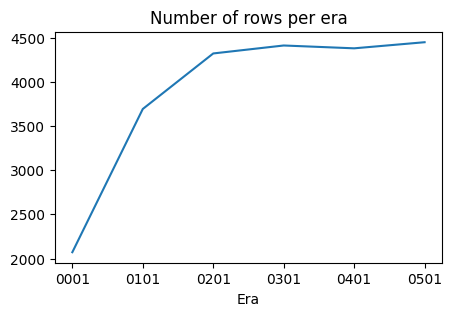

In [16]:
# Plot the number of rows per era
train.groupby("era").size().plot(title="Number of rows per era", figsize=(5, 3), xlabel="Era");

### Forward Selection

In [17]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from scipy import stats

def numerai_corr(target, preds):

    from scipy import stats

    # Check for NaN in inputs
    if np.isnan(preds).any() or np.isnan(target).any():
        print("NaN values found in predictions or target")
        return 0  # or handle it differently

    ranked_preds = (pd.Series(preds).rank(method="average").values - 0.5) / len(preds)
    gauss_ranked_preds = stats.norm.ppf(ranked_preds)

    # Check for NaN after transformations
    if np.isnan(gauss_ranked_preds).any():
        print("NaN values found after ranking and Gaussian transformation")
        return 0

    centered_target = target - np.mean(target)

    preds_p15 = np.sign(gauss_ranked_preds) * np.abs(gauss_ranked_preds) ** 1.5
    target_p15 = np.sign(centered_target) * np.abs(centered_target) ** 1.5

    # Check final correlation calculation
    corr = np.corrcoef(preds_p15, target_p15)[0, 1]
    if np.isnan(corr):
        print("NaN value in correlation calculation")
        return 0

    return corr


def forward_selection(data, target_name, n_splits=5):
    X = data.drop(columns=[target_name])  # Drop 'id' if it exists
    y = data[target_name]

    selected_features = []
    feature_scores = {}
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for i in range(X.shape[1]):
        best_score = -float('inf')
        best_feature = None

        print(f"Processing iteration {i+1}/{X.shape[1]}...")

        for feature in X.columns.difference(selected_features):
            current_features = selected_features + [feature]
            scores = []

            for train_index, test_index in kfold.split(X):
                X_train, X_test = X.iloc[train_index][current_features], X.iloc[test_index][current_features]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)
                model.fit(X_train, y_train)

                preds = model.predict(X_test)
                score = numerai_corr(pd.Series(preds), y_test)
                scores.append(score)

            avg_score = np.mean(scores)

            if avg_score > best_score:
                best_score = avg_score
                best_feature = feature

        if best_feature is not None:
            selected_features.append(best_feature)
            feature_scores[len(selected_features)] = {
                'features': list(selected_features),
                'score': best_score,
                'feature_count': len(selected_features)
            }
            print(f"Added feature: {best_feature} | Score: {best_score} | Feature count: {len(selected_features)}")
        else:
            print("No more features improving the score. Stopping selection.")
            break

    return feature_scores

In [ ]:
result = forward_selection(train[feature_cols + ['target']], 'target')
print(result)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit